In [ ]:
# Task 1: CNN Classification with Comprehensive Analysis 

In [10]:
#Phase 1: Install Dependencies (Colab Only)
!pip install medmnist

In [1]:
#Imports + Reproducibility

import torch
import numpy as np
import random
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import PneumoniaMNIST

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:
#Configuration

class Config:
    seed = 42
    batch_size = 64
    epochs = 30
    learning_rate = 1e-3
    weight_decay = 1e-4
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

In [3]:
#Transform Functions

def get_train_transforms(mean, std):
    return transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05)
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])


def get_val_test_transforms(mean, std):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])

In [4]:
#Compute Dataset Mean/Std

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PneumoniaMNIST


def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=256, shuffle=False)

    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)   # batch size
        images = images.view(batch_samples, images.size(1), -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean, std


# Transform: convert PIL → Tensor and scale to [0,1]
transform = transforms.ToTensor()

# Load dataset with transform
temp_dataset = PneumoniaMNIST(
    split='train',
    transform=transform,
    download=True
)

# Compute statistics
mean, std = compute_mean_std(temp_dataset)

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5719])
Std: tensor([0.1448])


In [5]:
#Create Dataloaders

train_dataset = PneumoniaMNIST(
    split='train',
    transform=get_train_transforms(mean, std),
    download=True
)

val_dataset = PneumoniaMNIST(
    split='val',
    transform=get_val_test_transforms(mean, std),
    download=True
)

test_dataset = PneumoniaMNIST(
    split='test',
    transform=get_val_test_transforms(mean, std),
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 74
Val batches: 9
Test batches: 10


In [9]:
## Phase 2: CNN Architecture

In [6]:
# CNN Implementation

import torch
import torch.nn as nn
import torch.nn.functional as F


class PneumoniaCNN(nn.Module):
    """
    Lightweight CNN optimized for 28x28 grayscale medical images.
    """

    def __init__(self):
        super(PneumoniaCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 28 -> 14

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 14 -> 7

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 7 -> 3

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)  # Binary classification

        self._initialize_weights()

    def forward(self, x):

        # Conv Block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Conv Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Conv Block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        """
        He initialization for Conv layers.
        Xavier for Linear layers.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

In [7]:
# ✅ This is How to Verify the CNN Model Is Working

model = PneumoniaCNN().to(config.device)

# Print architecture
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

# Dummy forward pass
dummy_input = torch.randn(4, 1, 28, 28).to(config.device)
output = model(dummy_input)

print("Output shape:", output.shape)

PneumoniaCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
Total parameters: 388802
Output shape: torch.Size([4, 2])


In [ ]:
## Phase 3: Training Engine

Current Learning Rate: 0.001000
Epoch [1/30]
Train Loss: 0.3590 | Train Acc: 0.8804
Val Loss: 0.1493 | Val Acc: 0.9408
----------------------------------------
✅ Best model saved.
Current Learning Rate: 0.001000
Epoch [2/30]
Train Loss: 0.1686 | Train Acc: 0.9356
Val Loss: 0.1127 | Val Acc: 0.9447
----------------------------------------
✅ Best model saved.
Current Learning Rate: 0.001000
Epoch [3/30]
Train Loss: 0.1465 | Train Acc: 0.9403
Val Loss: 0.1133 | Val Acc: 0.9542
----------------------------------------
Current Learning Rate: 0.001000
Epoch [4/30]
Train Loss: 0.1333 | Train Acc: 0.9516
Val Loss: 0.1283 | Val Acc: 0.9523
----------------------------------------
Current Learning Rate: 0.001000
Epoch [5/30]
Train Loss: 0.1246 | Train Acc: 0.9526
Val Loss: 0.1438 | Val Acc: 0.9542
----------------------------------------
Current Learning Rate: 0.001000
Epoch [6/30]
Train Loss: 0.1265 | Train Acc: 0.9486
Val Loss: 0.1042 | Val Acc: 0.9637
----------------------------------------


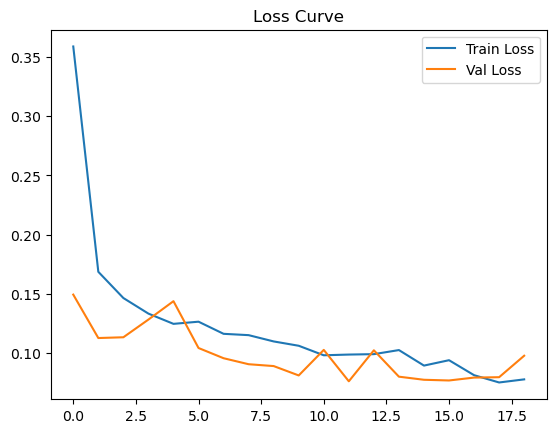

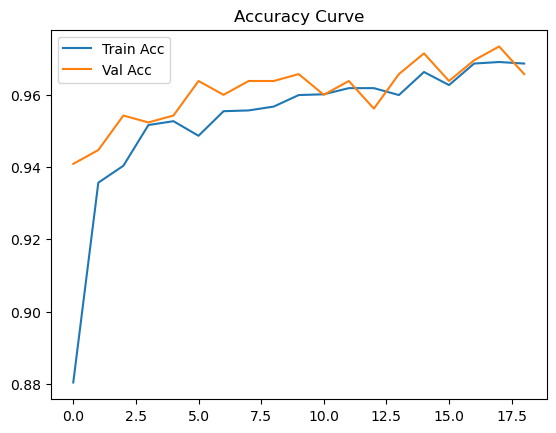

In [8]:
# 🔹 1️⃣ Loss, Optimizer, Scheduler

import os
import torch.optim as optim
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

os.makedirs("checkpoints", exist_ok=True)

# 🔹 2️⃣ Training & Validation Functions

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

# 🔹 3️⃣ Full Training Loop with Early Stopping

best_val_loss = float('inf')
early_stop_counter = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(config.epochs):

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, config.device
    )

    val_loss, val_acc = validate(
        model, val_loader, criterion, config.device
    )

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{config.epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("-" * 40)

    # Checkpoint saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")
        early_stop_counter = 0
        print("✅ Best model saved.")
    else:
        early_stop_counter += 1

    # Early stopping
    if early_stop_counter >= 7:
        print("⛔ Early stopping triggered.")
        break

# 🔹 4️⃣ Plot Training Curves

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()



In [ ]:
# ## Phase 4: Full Evaluation on Test Set

Test Metrics
-------------
Accuracy  : 0.8462
Precision : 0.8025
Recall    : 1.0000
F1-Score  : 0.8904
ROC-AUC   : 0.9666


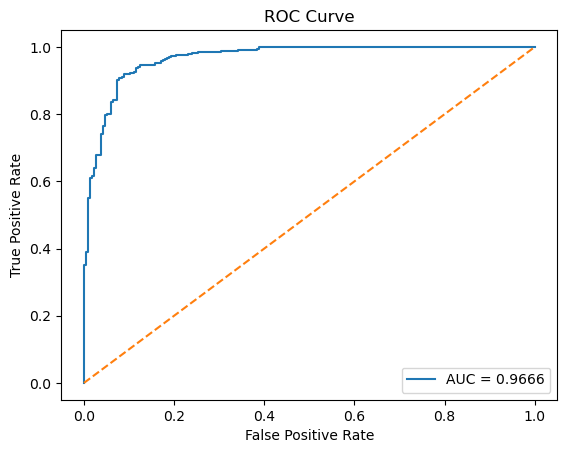

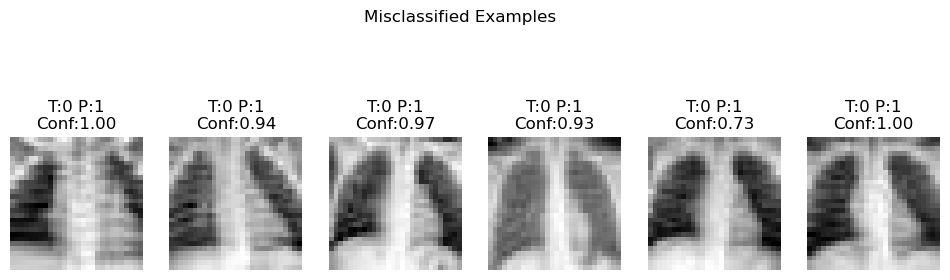

Total misclassified: 96


In [9]:
# 🔹 1️⃣ Load Best Model

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load best checkpoint
model.load_state_dict(torch.load("checkpoints/best_model.pth"))
model.eval()

# 🔹 2️⃣ Run Inference on Test Set

all_probs = []
all_preds = []
all_labels = []
misclassified_images = []
misclassified_info = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(config.device)
        labels = labels.squeeze().long().to(config.device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.extend(probs[:, 1].cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Collect failure cases
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_info.append(
                    (
                        labels[i].item(),
                        preds[i].item(),
                        probs[i][1].item()
                    )
                )

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 🔹 3️⃣ Compute Metrics

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print("Test Metrics")
print("-------------")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"ROC-AUC   : {auc:.4f}")

# 🔹 5️⃣ ROC Curve

fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 🔹 6️⃣ Failure Case Visualization (Critical Section)

num_to_show = min(6, len(misclassified_images))

plt.figure(figsize=(12, 4))

for i in range(num_to_show):
    img = misclassified_images[i].squeeze()
    true_label, pred_label, prob = misclassified_info[i]

    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{true_label} P:{pred_label}\nConf:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Misclassified Examples")
plt.show()

print("Total misclassified:", len(misclassified_images))



In [18]:
# Saving output files for exchanging with task 2

import pandas as pd
import numpy as np
import os

# 1️⃣ Create output folder for communication
os.makedirs("task1_output", exist_ok=True)

# 2️⃣ Save CNN predictions on test set
test_data = []

for idx, (img_tensor, label) in enumerate(test_loader):
    # Flatten batch
    img_tensor = img_tensor.squeeze(1)  # (batch, 28,28)
    for i in range(img_tensor.shape[0]):
        test_data.append({
            "image_index": idx*config.batch_size + i,
            "label": label[i].item(),
            "pred": all_preds[idx*config.batch_size + i],
            "prob": all_probs[idx*config.batch_size + i]
        })

# Save CSV
df_test = pd.DataFrame(test_data)
df_test.to_csv("task1_output/test_predictions.csv", index=False)

# 3️⃣ Optionally, save misclassified images
misclassified_images = np.stack([img.cpu().numpy() for img in misclassified_images])
misclassified_labels = np.array([info[0] for info in misclassified_info])
misclassified_preds = np.array([info[1] for info in misclassified_info])
misclassified_probs = np.array([info[2] for info in misclassified_info])

np.savez_compressed(
    "task1_output/misclassified_images.npz",
    images=misclassified_images,
    labels=misclassified_labels,
    preds=misclassified_preds,
    probs=misclassified_probs
)

print("Task 1 outputs saved to 'task1_output/' for Task 2 consumption.")

Task 1 outputs saved to 'task1_output/' for Task 2 consumption.
